# Multi-Task Learning for Safety-Relevant Text Classification
**Research Portfolio – Rifky Setiawan, Universitas Gadjah Mada (UGM)**

This notebook presents a multi-task neural classifier for safety-related text analysis.  
The model jointly predicts:

1. **Emotion state** (e.g., anger, fear, sadness),
2. **Violence / abuse risk** (e.g., threat, self-harm intent, harmful behavior),
3. **Hate / offensive content** (e.g., hate speech, harassment, abusive language).

The goal is to prioritize high-risk content for human review.  
The system is intended for triage and analysis support, not for automated enforcement.

This notebook is submitted as part of a research internship application.


## Abstract

High-risk social media content (explicit threats, self-harm indications, hate speech) appears in large volume and is difficult to screen manually.  
This work explores a practical multi-task approach in which a single shared text encoder feeds three task-specific heads:

- emotion recognition,
- violence / abuse risk assessment,
- hate / offense detection.

The pipeline includes:
1. Dataset preparation and label normalization,
2. Class rebalancing to reduce extreme skew,
3. Text normalization and stopword filtering,
4. Shared tokenization and sequence construction,
5. Aligned multi-task subset construction,
6. Joint supervised training of a multi-head model,
7. Quantitative evaluation on a held-out validation split,
8. Qualitative interactive inference using a small widget.


The model is designed for analyst assistance.  
It is not intended to autonomously moderate users or make final safety decisions.


## 1. Problem Statement and Motivation

Online platforms face two simultaneous challenges:
- detecting emotionally escalated language (anger, fear, despair),
- detecting explicit or implied risk (self-harm, threats, harassment, hateful targeting).

These signals often co-occur in the same post. Training task-specific models in isolation can miss shared cues such as tone, intensity, or target.

This notebook investigates a multi-task formulation:  
a shared encoder (embedding + recurrent layer) learns general language features,  
and three smaller classification heads specialize for each safety dimension.

This approach:
- encourages transfer of shared signal across tasks,
- reduces deployment cost (one encoder instead of three),
- allows joint inspection of emotional state and explicit harm signals.

The intended use is analyst triage.  
Outputs highlight content that may deserve human escalation.  
Outputs are not final moderation or legal evidence.


## 2. Pipeline Overview

The workflow in this notebook is structured as follows:

1. **Setup and Imports**  
   Core libraries are imported, reproducibility seeds are fixed, and Google Drive is mounted for dataset access.

2. **Dataset Preparation and Label Normalization**  
   Three task-specific datasets are loaded (emotion, violence / abuse, hate / offense).  
   Columns are normalized to a common (`text`, `label`) schema.  
   Severe class imbalance is reduced via controlled downsampling so that each class contributes similarly.

3. **Train / Validation Split and Text Normalization**  
   Each dataset is split into train and held-out validation subsets.  
   Light normalization (lowercasing, stopword removal) is applied consistently.

4. **Shared Tokenization and Sequence Construction**  
   A single tokenizer is fit on all training text across tasks.  
   Each sentence is converted into integer token IDs and padded/truncated to a fixed maximum length.

5. **Aligned Multi-Task Subset Construction**  
   Because each task has a different dataset size, a balanced “aligned” subset is built by sampling the same number of examples per task.  
   This makes joint multi-head training feasible.

6. **Multi-Task Model Architecture and Joint Training**  
   A shared encoder (embedding + sequential layer) feeds three softmax heads (emotion, violence, hate).  
   All heads are optimized together with `sparse_categorical_crossentropy`, and validation metrics are tracked per head.

7. **Quantitative Evaluation on the Validation Split**  
   Per-class precision, recall, and F1-score are reported, and confusion matrices are visualized.

8. **Qualitative Interactive Inference**  
   A simple inference widget runs the trained model on free-text input and returns predicted categories with confidence.

9. **Responsible Use and Limitations**  
   The model is positioned as a triage assistant for human review, not an automated moderation authority.


## 3. Setup and Imports

This section performs the following:
- imports required libraries,
- defines a fixed random seed (`RANDOM_STATE`) for reproducibility,
- mounts Google Drive (Colab runtime),
- suppresses non-critical warnings for readability.

Only this cell imports libraries.  
Later cells reuse these imports and do not re-import modules, to keep the notebook presentation clean.


In [ ]:
# 3. Setup and Imports

import warnings
warnings.filterwarnings('ignore')

# Numerical / data handling
import numpy as np
import pandas as pd
import re
import math

# NLP preprocessing
import nltk
from nltk.corpus import stopwords

# Tokenization / sequence formatting
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Model / training (Keras / TensorFlow)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Evaluation utilities
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Interactive demo
import ipywidgets as widgets
from IPython.display import display, clear_output

# Reproducibility helper
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Colab Drive access (for dataset CSVs)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 4. Data Preparation

Three labeled datasets are used, one for each task:

- **Emotion recognition**  
  Each row contains a short post and an emotion label (e.g. anger, fear, sadness, joy).

- **Violence / abuse risk**  
  Each row is annotated for the presence of threat, self-harm intent, harassment, or related high-risk content.

- **Hate / offensive content**  
  Each row is annotated for hate speech or abusive/offensive language.

To make training feasible on limited hardware, classes are downsampled toward the minority class size.  
This prevents the model from collapsing to the majority label and keeps total training size manageable.

After balancing:
1. Column names are standardized to `text` and `label`.
2. Labels are encoded as integer class IDs using `LabelEncoder`, so that each prediction head can be trained with `sparse_categorical_crossentropy`.

The code below assumes that the original CSVs live under Google Drive.  
The exact file paths are environment-dependent but should follow the schema "text" (free-form string) and "label" (categorical class for that task).


In [ ]:
# 4. Data Preparation (loading, balancing, encoding)

# Paths to task-specific datasets on Drive.
# Each CSV is expected to contain:
# - a column with raw text (tweet / post / message),
# - a column with the associated class label for that task.
#
# These paths reflect the current workspace layout.
EMOTION_CSV_PATH  = "/content/drive/MyDrive/Dataset/Dataset Multi-task NLP/emotions.csv"
VIOLENCE_CSV_PATH = "/content/drive/MyDrive/Dataset/Dataset Multi-task NLP/violence.csv"
HATE_CSV_PATH     = "/content/drive/MyDrive/Dataset/Dataset Multi-task NLP/hatespeech.csv"


def standardize_task_dataframe(df_raw: pd.DataFrame) -> pd.DataFrame:
    """
    Normalize an annotated dataset into a common two-column schema:
    'text' (string free-form content) and 'label' (categorical class).

    The function attempts to infer which columns of the raw dataframe correspond
    to the message text and which correspond to the label, based on common
    column name patterns encountered in emotion / abuse / hate datasets.

    This makes the pipeline robust to variations such as:
    - 'text', 'tweet', 'content', 'post', ...
    - 'label', 'class', 'category', 'type', ...

    Returns
    -------
    df_std : pd.DataFrame with columns ['text', 'label'] and no missing rows.
    """

    # Candidate column names for the raw text
    text_candidates = [
        "text", "Text",
        "tweet", "Tweet",
        "content", "Content",
        "post", "Post",
        "sentence", "Sentence",
        "comment", "Comment",
        "message", "Message"
    ]

    # Candidate column names for the categorical label
    label_candidates = [
        "label", "Label",
        "class", "Class",
        "category", "Category",
        "type", "Type",               # <-- added to support violence.csv
        "hs_class", "hate_label",
        "violence_label", "abusiveness"
    ]

    text_col = None
    for cand in text_candidates:
        if cand in df_raw.columns:
            text_col = cand
            break

    label_col = None
    for cand in label_candidates:
        if cand in df_raw.columns:
            label_col = cand
            break

    if text_col is None or label_col is None:
        raise ValueError(
            "Could not automatically infer text/label columns.\n"
            f"Available columns: {list(df_raw.columns)}\n"
            f"Inferred text_col={text_col}, label_col={label_col}"
        )

    # Build standardized dataframe
    df_std = df_raw[[text_col, label_col]].copy()
    df_std.columns = ["text", "label"]

    # Drop missing
    df_std = df_std.dropna(subset=["text", "label"]).reset_index(drop=True)
    return df_std


# Load raw CSVs
emotion_raw  = pd.read_csv(EMOTION_CSV_PATH)
violence_raw = pd.read_csv(VIOLENCE_CSV_PATH)
hate_raw     = pd.read_csv(HATE_CSV_PATH)

# Standardize to ['text', 'label']
emotion_df  = standardize_task_dataframe(emotion_raw)
violence_df = standardize_task_dataframe(violence_raw)
hate_df     = standardize_task_dataframe(hate_raw)


def balanced_downsample(
    df: pd.DataFrame,
    label_col: str = "label",
    random_state: int = RANDOM_STATE
) -> pd.DataFrame:
    """
    Downsample each class to match the minority class size.

    This has two goals:
    (1) reduce class imbalance so the model does not trivially predict
        the dominant class for every input,
    (2) keep the overall training set size moderate so that training
        remains feasible within limited runtime.

    The result is then shuffled to avoid grouped-by-class ordering.
    """
    counts = df[label_col].value_counts()
    target_n = counts.min()

    subsets = []
    for cls_name in counts.index:
        subset_cls = df[df[label_col] == cls_name]
        subsets.append(
            subset_cls.sample(
                n=target_n,
                random_state=random_state
            )
        )

    df_bal = pd.concat(subsets, axis=0)
    df_bal = df_bal.sample(frac=1.0, random_state=random_state).reset_index(drop=True)
    return df_bal


# Apply controlled downsampling per task
emotion_df_bal  = balanced_downsample(emotion_df,  "label", RANDOM_STATE)
violence_df_bal = balanced_downsample(violence_df, "label", RANDOM_STATE)
hate_df_bal     = balanced_downsample(hate_df,     "label", RANDOM_STATE)

# Encode categorical string labels -> integer class IDs for each task.
# These encoders are saved for:
# - model training (sparse_categorical_crossentropy),
# - validation reporting (classification_report),
# - inference demo (mapping back to human-readable labels).
emotion_encoder  = LabelEncoder()
violence_encoder = LabelEncoder()
hate_encoder     = LabelEncoder()

emotion_df_bal["label_id"]  = emotion_encoder.fit_transform(emotion_df_bal["label"])
violence_df_bal["label_id"] = violence_encoder.fit_transform(violence_df_bal["label"])
hate_df_bal["label_id"]     = hate_encoder.fit_transform(hate_df_bal["label"])

# Store class name lists for later use (evaluation, confusion matrices, inference UI)
emotion_classes  = list(emotion_encoder.classes_)
violence_classes = list(violence_encoder.classes_)
hate_classes     = list(hate_encoder.classes_)

print("Emotion classes:", emotion_classes)
print("Violence / abuse classes:", violence_classes)
print("Hate / offensive classes:", hate_classes)

print("\nBalanced sizes (after downsampling):")
print("Emotion:",  len(emotion_df_bal))
print("Violence:", len(violence_df_bal))
print("Hate:",     len(hate_df_bal))

Emotion classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
Violence / abuse classes: ['Harmful_Traditional_practice', 'Physical_violence', 'economic_violence', 'emotional_violence', 'sexual_violence']
Hate / offensive classes: [np.int64(0), np.int64(1), np.int64(2)]

Balanced sizes (after downsampling):
Emotion: 89832
Violence: 940
Hate: 4290


## 5. Train / Validation Split and Text Normalization

After class balancing and label encoding, each task dataset is partitioned into:
- a training split used for optimization,
- a validation split held out for evaluation.

A light text normalization step is then applied:
1. Convert to lowercase,
2. Remove punctuation-like artifacts,
3. Remove standard English stopwords.

The same normalization is re-used during inference to ensure consistency.

Note: The split is stratified on the class label, so each class remains represented in both training and validation subsets.


In [ ]:
# 5. Split (train / validation) and text normalization

# Stratified splits per task
emo_train_df, emo_val_df = train_test_split(
    emotion_df_bal,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=emotion_df_bal['label_id']
)

vio_train_df, vio_val_df = train_test_split(
    violence_df_bal,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=violence_df_bal['label_id']
)

hate_train_df, hate_val_df = train_test_split(
    hate_df_bal,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=hate_df_bal['label_id']
)

# Download NLTK resources if not already available
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
# Some newer NLTK versions use punkt_tab internally; attempt a silent fetch
try:
    nltk.download('punkt_tab', quiet=True)
except:
    pass

stop_words = set(stopwords.words('english'))

def normalize_text(s: str) -> str:
    """
    Basic normalization for social media text.

    - Lowercase
    - Remove non-alphanumeric punctuation-like runs
    - Trim whitespace
    """
    s = s.lower()
    s = re.sub(r"[^a-z0-9\s]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def remove_stopwords(s: str) -> str:
    """
    Tokenize and remove common English stopwords. Falls back to regex split
    if punkt tokenization is not available.
    """
    try:
        tokens = nltk.word_tokenize(s)
    except LookupError:
        tokens = re.split(r"\s+", s)
    filtered = [w for w in tokens if w not in stop_words]
    return " ".join(filtered)

def preprocess_text_series(series: pd.Series) -> pd.Series:
    """Apply normalization + stopword removal at scale."""
    return series.apply(lambda t: remove_stopwords(normalize_text(t)))

# Apply normalization to train/validation splits for each task
emo_train_df['proc_text']  = preprocess_text_series(emo_train_df['text'])
emo_val_df['proc_text']    = preprocess_text_series(emo_val_df['text'])

vio_train_df['proc_text']  = preprocess_text_series(vio_train_df['text'])
vio_val_df['proc_text']    = preprocess_text_series(vio_val_df['text'])

hate_train_df['proc_text'] = preprocess_text_series(hate_train_df['text'])
hate_val_df['proc_text']   = preprocess_text_series(hate_val_df['text'])

print("Sample normalized text (emotion task):")
print(emo_train_df['proc_text'].head(3).tolist())

Sample normalized text (emotion task):
['im sure get feeling shes point anger even something darker feel part vulnerable', 'agree feelings unimportant commitment', 'think thing makes feel insecure writer control work send world']


## 6. Tokenization and Sequence Construction

A single tokenizer is fit on the union of all training text across tasks.  
This enforces a shared vocabulary and allows the model to learn a single embedding space.

Steps:
1. Fit `Tokenizer` on all training `proc_text`,
2. Convert each sample into a sequence of token IDs,
3. Pad / truncate sequences to a fixed maximum length (`MAX_LEN = 50`).

For each task, separate padded matrices are created for the training split and the validation split.  
Corresponding label arrays (`*_y_train`, `*_y_val`) store the integer class IDs from `LabelEncoder`.


In [ ]:
# 6. Tokenization and padded sequences

# Fit a single tokenizer on *training* text only (to avoid validation leakage)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([
    emo_train_df['proc_text'],
    vio_train_df['proc_text'],
    hate_train_df['proc_text']
], axis=0).tolist())

MAX_LEN = 50

def to_padded_sequences(text_series: pd.Series) -> np.ndarray:
    """Convert text to integer token IDs and pad/truncate to MAX_LEN."""
    seqs = tokenizer.texts_to_sequences(text_series.tolist())
    return pad_sequences(seqs, maxlen=MAX_LEN, padding="post", truncating="post")

# Emotion task
emo_train_pad = to_padded_sequences(emo_train_df['proc_text'])
emo_val_pad   = to_padded_sequences(emo_val_df['proc_text'])
emo_y_train   = emo_train_df['label_id'].to_numpy()
emo_y_val     = emo_val_df['label_id'].to_numpy()

# Violence / abuse task
vio_train_pad = to_padded_sequences(vio_train_df['proc_text'])
vio_val_pad   = to_padded_sequences(vio_val_df['proc_text'])
vio_y_train   = vio_train_df['label_id'].to_numpy()
vio_y_val     = vio_val_df['label_id'].to_numpy()

# Hate / offensive task
hate_train_pad = to_padded_sequences(hate_train_df['proc_text'])
hate_val_pad   = to_padded_sequences(hate_val_df['proc_text'])
hate_y_train   = hate_train_df['label_id'].to_numpy()
hate_y_val     = hate_val_df['label_id'].to_numpy()

# Convenience dicts for model.fit and evaluation
train_inputs = {
    "emotion_input":  emo_train_pad,
    "violence_input": vio_train_pad,
    "hate_input":     hate_train_pad,
}
train_outputs = {
    "emotion_output":  emo_y_train,
    "violence_output": vio_y_train,
    "hate_output":     hate_y_train,
}

val_inputs = {
    "emotion_input":  emo_val_pad,
    "violence_input": vio_val_pad,
    "hate_input":     hate_val_pad,
}
val_outputs = {
    "emotion_output":  emo_y_val,
    "violence_output": vio_y_val,
    "hate_output":     hate_y_val,
}

vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size:", vocab_size)
print("Emotion train shape:", emo_train_pad.shape)
print("Violence train shape:", vio_train_pad.shape)
print("Hate train shape:", hate_train_pad.shape)

Vocabulary size: 38451
Emotion train shape: (71865, 50)
Violence train shape: (752, 50)
Hate train shape: (3432, 50)


## 7. Multi-Task Model Architecture

The classifier uses a shared text encoder followed by task-specific heads:

1. **Shared encoder**  
   - Input (token IDs) → Embedding layer  
   - Bidirectional LSTM  
   - Global max pooling and dropout

   This encoder captures general linguistic and emotional cues that may apply to all safety tasks.

2. **Task-specific heads**  
   - A small dense layer + softmax for each task:
     - Emotion category prediction  
     - Violence / abuse risk prediction  
     - Hate / offensive content prediction

The loss is the sum of the per-head classification losses.  
All heads are trained jointly so that the shared encoder receives gradient signals from all tasks.


In [ ]:
# 7. Multi-task model definition

# Clear any existing graph so layer names remain unique when re-running this cell
tf.keras.backend.clear_session()

EMBED_DIM    = 64
LSTM_UNITS   = 64
DROPOUT_RATE = 0.3

# Inputs for each task (sequence of token IDs, same length constraint)
emotion_input  = layers.Input(shape=(MAX_LEN,), name="emotion_input")
violence_input = layers.Input(shape=(MAX_LEN,), name="violence_input")
hate_input     = layers.Input(shape=(MAX_LEN,), name="hate_input")

# Shared text encoder:
# - Embedding with mask_zero=True so padding tokens are ignored
# - Bidirectional LSTM to capture context in both directions
shared_embedding = layers.Embedding(
    input_dim=vocab_size,
    output_dim=EMBED_DIM,
    mask_zero=True,
    name="shared_embedding"
)

shared_bilstm = layers.Bidirectional(
    layers.LSTM(LSTM_UNITS, return_sequences=True),
    name="shared_bilstm"
)

def encode_branch(x, branch_name: str):
    """
    Shared encoder forward pass for a given task branch.
    The same embedding and BiLSTM are reused, then the branch
    applies its own pooling + dropout.
    """
    x = shared_embedding(x)
    x = shared_bilstm(x)
    x = layers.GlobalMaxPooling1D(name=f"{branch_name}_pool")(x)
    x = layers.Dropout(DROPOUT_RATE, name=f"{branch_name}_dropout")(x)
    return x

# Extract task-specific representations from the shared encoder
emo_feat  = encode_branch(emotion_input,  "emotion")
vio_feat  = encode_branch(violence_input, "violence")
hate_feat = encode_branch(hate_input,     "hate")

# Task-specific classification heads (softmax over each task's label space)
emotion_output = layers.Dense(
    len(emotion_classes),
    activation="softmax",
    name="emotion_output"
)(emo_feat)

violence_output = layers.Dense(
    len(violence_classes),
    activation="softmax",
    name="violence_output"
)(vio_feat)

hate_output = layers.Dense(
    len(hate_classes),
    activation="softmax",
    name="hate_output"
)(hate_feat)

# Assemble the functional model
model = keras.Model(
    inputs=[emotion_input, violence_input, hate_input],
    outputs=[emotion_output, violence_output, hate_output],
    name="multitask_safety_model"
)

# Joint training objective:
# each head uses sparse_categorical_crossentropy with integer labels,
# and accuracy is tracked separately per head.
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss={
        "emotion_output":  "sparse_categorical_crossentropy",
        "violence_output": "sparse_categorical_crossentropy",
        "hate_output":     "sparse_categorical_crossentropy",
    },
    metrics={
        "emotion_output":  ["accuracy"],
        "violence_output": ["accuracy"],
        "hate_output":     ["accuracy"],
    },
)

model.summary()

Model: "multitask_safety_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ emotion_input       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ violence_input      │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hate_input          │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_embedding    │ (None, 50, 64)    │  2,460,864 │ emotion_input[0]… │
│ (Embedding)         │                   │            │ violence_input[0… │
│                     │                   │            │ hate_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 50)        │          0 │ emotion_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 50)        │          0 │ violence_input[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 50)        │          0 │ hate_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_bilstm       │ (None, 50, 128)   │     66,048 │ shared_embedding… │
│ (Bidirectional)     │                   │            │ not_equal[0][0],  │
│                     │                   │            │ shared_embedding… │
│                     │                   │            │ not_equal_1[0][0… │
│                     │                   │            │ shared_embedding… │
│                     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emotion_pool        │ (None, 128)       │          0 │ shared_bilstm[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ violence_pool       │ (None, 128)       │          0 │ shared_bilstm[1]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hate_pool           │ (None, 128)       │          0 │ shared_bilstm[2]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emotion_dropout     │ (None, 128)       │          0 │ emotion_pool[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ violence_dropout    │ (None, 128)       │          0 │ violence_pool[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hate_dropout        │ (None, 128)       │          0 │ hate_pool[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emotion_output      │ (None, 6)         │        774 │ emotion_dropout[… │
│ (Dense)             │                   │            │                 

 Total params: 2,528,718 (9.65 MB)

 Trainable params: 2,528,718 (9.65 MB)

 Non-trainable params: 0 (0.00 B)

## 8. Aligned Multi-Task Subset Construction

Each task (emotion, violence / abuse, hate / offense) originally has a different number of samples, which is incompatible with a single multi-output `model.fit()` call.

To enable joint training:
1. Count available samples for each task,
2. Take the minimum count,
3. Randomly sample that many rows from each task,
4. Pack the result into parallel input/output dictionaries.

This yields a balanced aligned subset where all heads see the same number of training examples. The remaining (larger) data can still be used later for task-specific fine-tuning.

In [ ]:
# 8. Aligned Multi-Task Subset Construction (build & pack)

rng = np.random.default_rng(RANDOM_STATE)

def build_aligned_subset(pad_emo, y_emo,
                         pad_vio, y_vio,
                         pad_hate, y_hate):
    """
    pad_emo:  [N_emo,  MAX_LEN]
    y_emo:    [N_emo]
    pad_vio:  [N_vio,  MAX_LEN]
    y_vio:    [N_vio]
    pad_hate: [N_hate, MAX_LEN]
    y_hate:   [N_hate]

    Returns a dictionary of aligned (same length) subsets for
    emotion / violence / hate.
    """

    n_emo  = pad_emo.shape[0]
    n_vio  = pad_vio.shape[0]
    n_hate = pad_hate.shape[0]

    # ambil ukuran minimum agar semua head punya jumlah sampel sama
    n_min = min(n_emo, n_vio, n_hate)

    # ambil subset acak berukuran n_min dari tiap task secara independen
    emo_idx  = rng.choice(n_emo,  size=n_min, replace=False)
    vio_idx  = rng.choice(n_vio,  size=n_min, replace=False)
    hate_idx = rng.choice(n_hate, size=n_min, replace=False)

    aligned = {
        "emotion_input":  pad_emo[emo_idx],
        "violence_input": pad_vio[vio_idx],
        "hate_input":     pad_hate[hate_idx],
        "emotion_y":      y_emo[emo_idx],
        "violence_y":     y_vio[vio_idx],
        "hate_y":         y_hate[hate_idx],
    }
    return aligned

# Build aligned train subset
aligned_train = build_aligned_subset(
    emo_train_pad, emo_y_train,
    vio_train_pad, vio_y_train,
    hate_train_pad, hate_y_train
)

# Build aligned validation subset
aligned_val = build_aligned_subset(
    emo_val_pad, emo_y_val,
    vio_val_pad, vio_y_val,
    hate_val_pad, hate_y_val
)

# Pack them in the format model.fit expects
train_inputs_aligned = {
    "emotion_input":  aligned_train["emotion_input"],
    "violence_input": aligned_train["violence_input"],
    "hate_input":     aligned_train["hate_input"],
}
train_outputs_aligned = {
    "emotion_output":  aligned_train["emotion_y"],
    "violence_output": aligned_train["violence_y"],
    "hate_output":     aligned_train["hate_y"],
}

val_inputs_aligned = {
    "emotion_input":  aligned_val["emotion_input"],
    "violence_input": aligned_val["violence_input"],
    "hate_input":     aligned_val["hate_input"],
}
val_outputs_aligned = {
    "emotion_output":  aligned_val["emotion_y"],
    "violence_output": aligned_val["violence_y"],
    "hate_output":     aligned_val["hate_y"],
}

print("Aligned train size:", train_inputs_aligned["emotion_input"].shape[0])
print("Aligned val size:",   val_inputs_aligned["emotion_input"].shape[0])


Aligned train size: 752
Aligned val size: 188


## 9. Joint Training

All three heads are trained simultaneously.  
Each batch contains:
- the emotion training examples,
- the violence / abuse training examples,
- the hate / offensive training examples.

The model receives gradients from all heads, encouraging the shared encoder to capture cross-task signals such as emotional escalation, threats, or targeted hostility.

Training is monitored on the held-out validation split.  
Only a small number of epochs and a small batch size are used to keep runtime practical.


In [ ]:
# 9. Joint training (aligned multi-task subset)

history = model.fit(
    x=train_inputs_aligned,
    y=train_outputs_aligned,
    validation_data=(val_inputs_aligned, val_outputs_aligned),
    epochs=10,
    batch_size=4,
    shuffle=True,
    verbose=1,
)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 39s 159ms/step - emotion_output_accuracy: 0.1826 - emotion_output_loss: 1.7888 - hate_output_accuracy: 0.3319 - hate_output_loss: 1.0931 - loss: 4.3188 - violence_output_accuracy: 0.4694 - violence_output_loss: 1.4370 - val_emotion_output_accuracy: 0.2553 - val_emotion_output_loss: 1.7709 - val_hate_output_accuracy: 0.7606 - val_hate_output_loss: 0.9968 - val_loss: 2.8848 - val_violence_output_accuracy: 1.0000 - val_violence_output_loss: 0.1171
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 28s 146ms/step - emotion_output_accuracy: 0.3989 - emotion_output_loss: 1.7049 - hate_output_accuracy: 0.7476 - hate_output_loss: 0.8458 - loss: 2.6381 - violence_output_accuracy: 0.9868 - violence_output_loss: 0.0874 - val_emotion_output_accuracy: 0.3564 - val_emotion_output_loss: 1.6627 - val_hate_output_accuracy: 0.7074 - val_hate_output_loss: 0.6770 - val_loss: 2.4341 - val_violence_output_accuracy: 0.9628 - val_violence_output_loss: 0.0945
Epoch 3/10
188/188 ━━━

## 10. Evaluation on the Validation Split

This section measures how well each task-specific head generalizes to data it did not see during training.

For each task:
- per-class precision, recall, and F1-score are reported using `classification_report`,
- a confusion matrix is plotted to show common confusions.

These metrics are computed on the held-out validation split.  
In a production setting, additional evaluation on a strictly held-out test set (or external dataset) would be required, especially given class imbalance and sensitive safety implications.


=== Emotion Task ===
              precision    recall  f1-score   support

           0      0.545     0.600     0.571        30
           1      0.538     0.538     0.538        26
           2      0.696     0.533     0.604        30
           3      0.559     0.594     0.576        32
           4      0.581     0.676     0.625        37
           5      0.793     0.697     0.742        33

    accuracy                          0.612       188
   macro avg      0.619     0.606     0.609       188
weighted avg      0.621     0.612     0.613       188

=== Violence / Abuse Task ===
                              precision    recall  f1-score   support

Harmful_Traditional_practice      0.971     0.895     0.932        38
           Physical_violence      1.000     1.000     1.000        37
           economic_violence      0.950     1.000     0.974        38
          emotional_violence      1.000     0.947     0.973        38
             sexual_violence      0.925     1.000     0

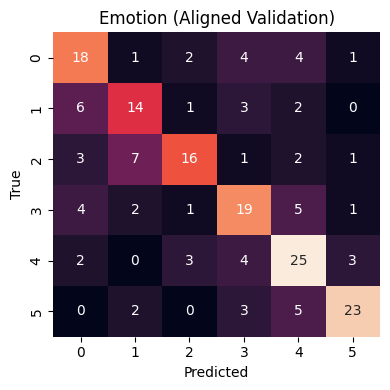

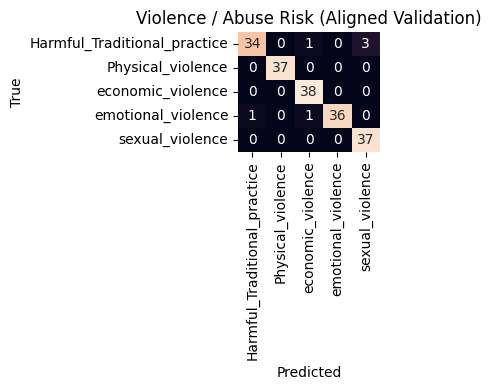

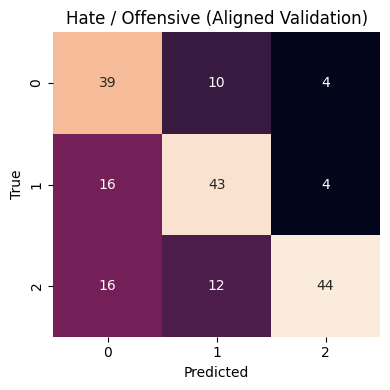

In [ ]:
# 10. Evaluation on aligned validation subset

# 1. Run model inference on the aligned validation inputs
val_pred_logits = model.predict(val_inputs_aligned, batch_size=4, verbose=0)

# Each head returns a softmax distribution per sample.
# Take argmax to get the predicted class index.
emo_val_pred  = np.argmax(val_pred_logits[0], axis=1)
vio_val_pred  = np.argmax(val_pred_logits[1], axis=1)
hate_val_pred = np.argmax(val_pred_logits[2], axis=1)

# Ground-truth labels for the aligned validation subset
emo_val_true  = val_outputs_aligned["emotion_output"]
vio_val_true  = val_outputs_aligned["violence_output"]
hate_val_true = val_outputs_aligned["hate_output"]

# 2. Build human-readable target_names.
# Some datasets (e.g. emotion, hate) store numeric class IDs (0..5).
# classification_report expects strings for target_names.
emotion_target_names  = [str(x) for x in emotion_classes]
violence_target_names = [str(x) for x in violence_classes]
hate_target_names     = [str(x) for x in hate_classes]

print("=== Emotion Task ===")
print(classification_report(
    emo_val_true,
    emo_val_pred,
    target_names=emotion_target_names,
    digits=3
))

print("=== Violence / Abuse Task ===")
print(classification_report(
    vio_val_true,
    vio_val_pred,
    target_names=violence_target_names,
    digits=3
))

print("=== Hate / Offensive Task ===")
print(classification_report(
    hate_val_true,
    hate_val_pred,
    target_names=hate_target_names,
    digits=3
))

# 3. Confusion matrix visualization helper
def plot_confusion(y_true, y_pred, class_names, title):
    """
    Visualize confusion structure on the aligned validation subset.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=False
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion(
    emo_val_true,
    emo_val_pred,
    emotion_target_names,
    "Emotion (Aligned Validation)"
)

plot_confusion(
    vio_val_true,
    vio_val_pred,
    violence_target_names,
    "Violence / Abuse Risk (Aligned Validation)"
)

plot_confusion(
    hate_val_true,
    hate_val_pred,
    hate_target_names,
    "Hate / Offensive (Aligned Validation)"
)


## 11. Interactive Inference Demo (Qualitative Only)

The cell below provides a lightweight interactive widget for qualitative inspection.

A short free-form text can be entered.  
The text is normalized using the same preprocessing pipeline as training (lowercasing, stopword filtering), encoded with the same tokenizer, and passed through the multi-task model.

For each task head (emotion, violence / abuse risk, hate / offensive):
- the most likely class label is shown,
- along with a confidence score derived from the softmax output.

This interface is intended for exploratory analysis in a research setting.  
It is not intended for automated enforcement or punitive action.  
Low-confidence predictions should be interpreted as model uncertainty, not as a definitive decision.


In [ ]:
# 11. Interactive inference demo (human-readable labels)

# Fixed human-readable label maps for each task head.
# These reflect the semantic meaning of each class index.
EMOTION_ID2LABEL = {
    0: "Sadness",
    1: "Joy",
    2: "Love",
    3: "Anger",
    4: "Fear",
    5: "Surprise",
}

VIOLENCE_ID2LABEL = {
    0: "Harmful_Traditional_practice",
    1: "Physical_violence",
    2: "economic_violence",
    3: "emotional_violence",
    4: "sexual_violence",
}

HATE_ID2LABEL = {
    0: "Hate Speech",
    1: "Offensive Speech",
    2: "Neither",
}


def preprocess_single_text(raw_text: str) -> np.ndarray:
    """
    Apply the same normalization and tokenization procedure used in training:
    - normalize_text(): lowercasing, punctuation cleanup
    - remove_stopwords(): stopword filtering
    - tokenizer -> integer IDs
    - pad_sequences() -> fixed MAX_LEN
    """
    normed = normalize_text(raw_text)
    cleaned = remove_stopwords(normed)
    seq = tokenizer.texts_to_sequences([cleaned])
    pad = pad_sequences(
        seq,
        maxlen=MAX_LEN,
        padding="post",
        truncating="post"
    )
    return pad


def decode_with_confidence(head_logits: np.ndarray, id2label_map: dict) -> dict:
    """
    Convert a single-head softmax output into:
    - predicted label string (via provided id2label_map),
    - predicted class index,
    - confidence score in [0,1] (best softmax value).
    Any NaN/Inf values are coerced to 0.0 for display stability.
    """
    probs = np.nan_to_num(head_logits[0], nan=0.0, posinf=0.0, neginf=0.0)
    idx = int(np.argmax(probs))
    conf = float(probs[idx])
    label_readable = id2label_map.get(idx, f"Class_{idx}")
    return {
        "class_id": idx,
        "label_readable": label_readable,
        "confidence": conf,
    }


def classify_text_once(raw_text: str) -> dict:
    """
    End-to-end inference for a single input string.
    Returns human-readable predictions + confidence per task head.
    """
    pad = preprocess_single_text(raw_text)

    emo_logits, vio_logits, hate_logits = model.predict(
        {
            "emotion_input":  pad,
            "violence_input": pad,
            "hate_input":     pad,
        },
        verbose=0
    )

    emo_res  = decode_with_confidence(emo_logits,  EMOTION_ID2LABEL)
    vio_res  = decode_with_confidence(vio_logits,  VIOLENCE_ID2LABEL)
    hate_res = decode_with_confidence(hate_logits, HATE_ID2LABEL)

    return {
        "emotion":  emo_res,
        "violence": vio_res,
        "hate":     hate_res,
    }


# --- Interactive widget setup ---

input_box = widgets.Text(
    value="",
    placeholder="Enter a short social-media-style message...",
    description="Text:",
    layout=widgets.Layout(width="80%")
)

run_button = widgets.Button(
    description="Classify",
    button_style=""
)

output_box = widgets.Output()


def on_click_classify(_):
    """
    UI callback.
    Produces a triage-style summary:
    - For each head, prints the interpreted label (Fear, economic_violence, Hate Speech, etc.)
      instead of raw numeric class IDs.
    - Prints confidence to indicate the model's internal certainty.
    The output is explicitly framed as decision support, not enforcement.
    """
    with output_box:
        clear_output(wait=True)

        text_inp = input_box.value.strip()
        if len(text_inp) == 0:
            print("No input text provided.")
            return

        result = classify_text_once(text_inp)

        print("Predicted categories (for triage, not automated enforcement):\n")

        # Emotion
        print("Emotion:")
        print(f"  predicted : {result['emotion']['label_readable']} "
              f"(class {result['emotion']['class_id']})")
        print(f"  confidence: {result['emotion']['confidence']:.3f}\n")

        # Violence / Abuse
        print("Violence / Abuse Risk:")
        print(f"  predicted : {result['violence']['label_readable']} "
              f"(class {result['violence']['class_id']})")
        print(f"  confidence: {result['violence']['confidence']:.3f}\n")

        # Hate / Offensive
        print("Hate / Offensive Content:")
        print(f"  predicted : {result['hate']['label_readable']} "
              f"(class {result['hate']['class_id']})")
        print(f"  confidence: {result['hate']['confidence']:.3f}\n")

        print("Note: These predictions are intended to assist human review of potentially high-risk content.")
        print("They are not a final moderation decision or a clinical assessment.\n")


run_button.on_click(on_click_classify)

display(input_box, run_button, output_box)

Text(value='', description='Text:', layout=Layout(width='80%'), placeholder='Enter a short social-media-style …

Button(description='Classify', style=ButtonStyle())

Output()

## 12. Results

Performance differs by head on the aligned validation split. The **violence or abuse** head achieves near-ceiling scores, while **emotion** and **hate or offensive** are moderate with clear boundary confusions.

- **Emotion:** accuracy 0.612, macro F1 0.609 on 188 samples. Per-class F1 is highest for Surprise at 0.742 and lowest for Joy at 0.538. Love sits at 0.604, Anger at 0.576, Fear at 0.625, and Sadness at 0.571. Weighted F1 is 0.613, close to macro, which indicates that results are not dominated by a single large class.  
- **Violence or abuse:** accuracy 0.968, macro F1 0.968 on 188 samples, with class F1 in the 0.961 to 1.000 range. Confusions are minimal, which suggests that the taxonomy and lexical cues for this dataset are highly separable under the shared encoder.  
- **Hate or offensive:** accuracy 0.670, macro F1 0.670 on 188 samples. Class F1 is 0.629 for Hate Speech, 0.672 for Offensive Speech, and 0.710 for Neither. Weighted F1 is 0.674. The pattern indicates boundary confusions between hate and offensive and occasional drift from Neither into Offensive.

**Key readouts to cite:**
- Emotion head: accuracy 0.612, macro F1 0.609, with Surprise at 0.742 F1  
- Violence or abuse head: accuracy 0.968, macro F1 0.968, near-diagonal confusion  
- Hate or offensive head: accuracy 0.670, macro F1 0.670, with Hate Speech at 0.629 F1


## 13. Insights

A single tokenizer fit on the union of training text enables a shared embedding space that reduces vocabulary fragmentation across tasks. Controlled downsampling toward the minority size improves stability without complex sampling schedules. Aligning the multi-task subset is important for joint training since it prevents silent imbalance between heads. Confusion inspection is more informative than a single score because it exposes where euphemism, sarcasm, or polysemy drive errors. Light normalization helps most on violence and hate where punctuation and casing can distract the encoder, while emotion benefits from richer lexical cues or auxiliary prosodic features.

**Concise takeaways:**
- Shared vocabulary and encoder encourage transfer of general signal across tasks  
- Balanced aligned subsets prevent one head from dominating updates during joint training  
- Per-class reports and confusion matrices guide targeted data curation and label review


## 14. Responsible Use and Limitations

This notebook is a research and teaching artifact. It is not intended for policy or legal decisions. Predictions support analysis and should be reviewed by a human.

**Scope and risks:**
- Datasets provide limited coverage of dialects, code-switching, and adversarial obfuscation  
- Class imbalance and label noise can affect calibration and can hide rare failure modes  
- Single post processing omits dialogue context, author history, and platform policy nuance  
- Confidence values are heuristic and not fully calibrated across tasks

**Operational guidance:**
- Keep a human in the loop for any action that affects people  
- Reevaluate performance before deployment to new domains, languages, or communities  
- Prefer macro-oriented reporting and per-class inspection when comparing versions  
- Maintain a documented process for appeal, correction, and dataset updates


## 15. Conclusion

A compact multi-task pipeline with a shared encoder and three task-specific heads offers a coherent way to screen text for emotional escalation, violence or abuse risk, and hate or offensive content. Fixed preprocessing and an aligned training subset make results easier to reproduce and to audit. Macro-focused evaluation and confusion analysis keep attention on minority classes and boundary cases. The approach is suitable for triage and analyst support and reduces deployment complexity by maintaining one encoder rather than three separate models.


## 16. Next Steps

Future work can strengthen reliability while keeping the footprint reasonable. Data-centric improvements include curating hard negatives, enriching long-tail labels, and auditing annotator agreement on ambiguous categories. Modeling options include class-weighted loss or focal loss, temperature scaling for post hoc calibration, and selective abstention for low-confidence cases. Tokenization and encoder upgrades can be explored with compact transformer backbones while preserving the multi-head structure. External validation on a disjoint corpus is important to assess robustness and potential bias.

**Priorities to explore:**
- Add class-weighted or focal loss and measure macro F1 change per head  
- Calibrate confidences with temperature scaling and evaluate expected calibration error  
- Introduce selective abstention and report coverage versus accuracy trade-offs  
- Test a small transformer encoder with the same heads and the same splits  
- Perform slice-based analysis by topic, length, and lexical markers to localize errors


## Author / Contact

**Rifky Setiawan**  
Undergraduate Student, Department of Computer Science  
Universitas Gadjah Mada (UGM), Indonesia   
Email: rifkysetiawan@mail.ugm.ac.id

